In [1]:
!pip install graphviz

import graphviz
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

                                              0.0/47.1 kB ? eta -:--:--
     ---------------------------------------- 47.1/47.1 kB ? eta 0:00:00


#### Goal
Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it).
The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.
This challenge is significantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges.

#### Data Description
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

We want to:
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate

In [2]:
df = pd.read_csv('conversion_project.csv')

In [3]:
df

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


- country : user country based on the IP address (category data)
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source; (category data) 1. Ads: came to the site by clicking on an advertisement. 2. Seo: came to the site by clicking on search results. 3. Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. 

The company goal is to **increase conversion rate: # conversions / total sessions**

In [4]:
df.info() # no null and propor data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


A few quick observations:
- user base is pretty yound, but need to deal with age outliers 
- converted rate is around 0.03, which is industrial standard

#### Handle Age Outliers
Let's say the age is below 100 years old

In [6]:
df[df['age'] > 100] #only 2 users, we can remove them

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [7]:
df = df[df.age<= 100]

#### 1. Exploratory Data Analysis
#### Country and conversion rate
- mean conversion rate per country, we can see Chinese conversion rate is much lower than others
- German has high conversion rate

Compare the converted and un-converted group, 
- China have really big gap of count between converted and not converted
- But not much user relatively in German

In [8]:
df[['country','converted']].groupby('country').mean().sort_values(by='converted', ascending=False)

,converted
country,
Germany,0.062428
UK,0.052612
US,0.037801
China,0.001332


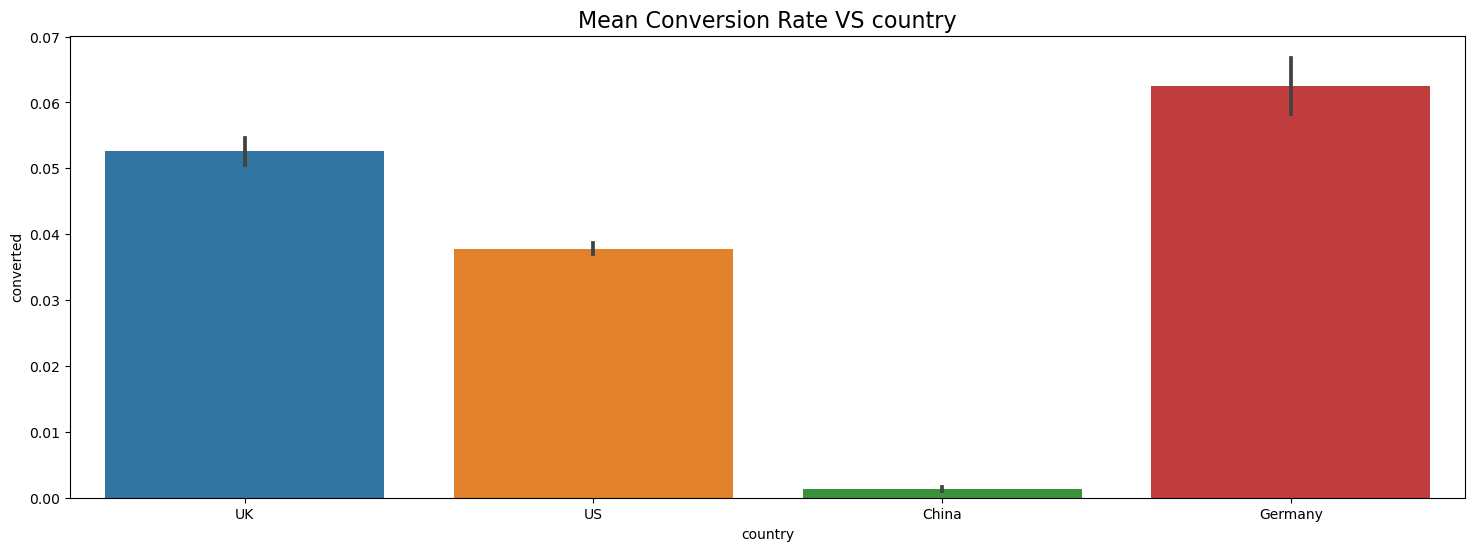

In [9]:
plt.figure(figsize=(18,6))
sns.barplot(x='country',y='converted', data= df)
plt.title('Mean Conversion Rate VS country', fontsize=16);

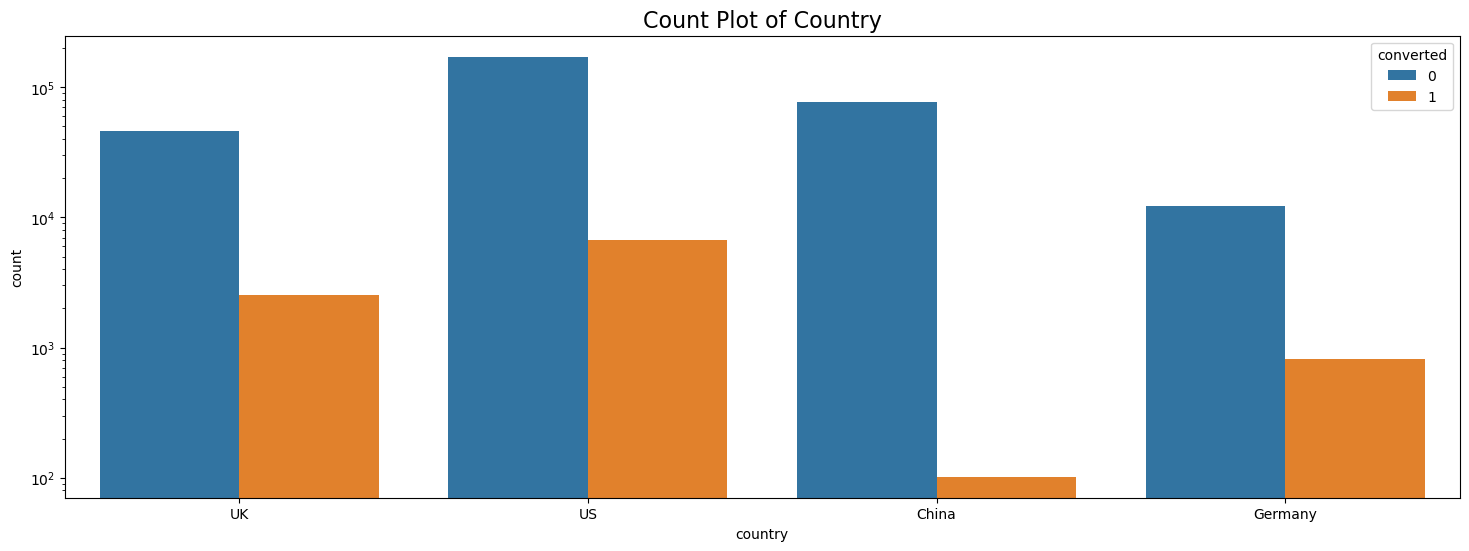

In [10]:
plt.figure(figsize=(18,6))
sns.countplot(x='country', hue='converted', data=df)
plt.title('Count Plot of Country', fontsize=16)
plt.yscale('log'); # y axis unit need to change

##### Source and conversion rate
According to source, Ads have the most converted rate among three. Seo is also have similar one.

In [11]:
df.groupby('source')['converted'].mean().sort_values(ascending=False) 

source
Ads       0.034472
Seo       0.032888
Direct    0.028169
Name: converted, dtype: float64

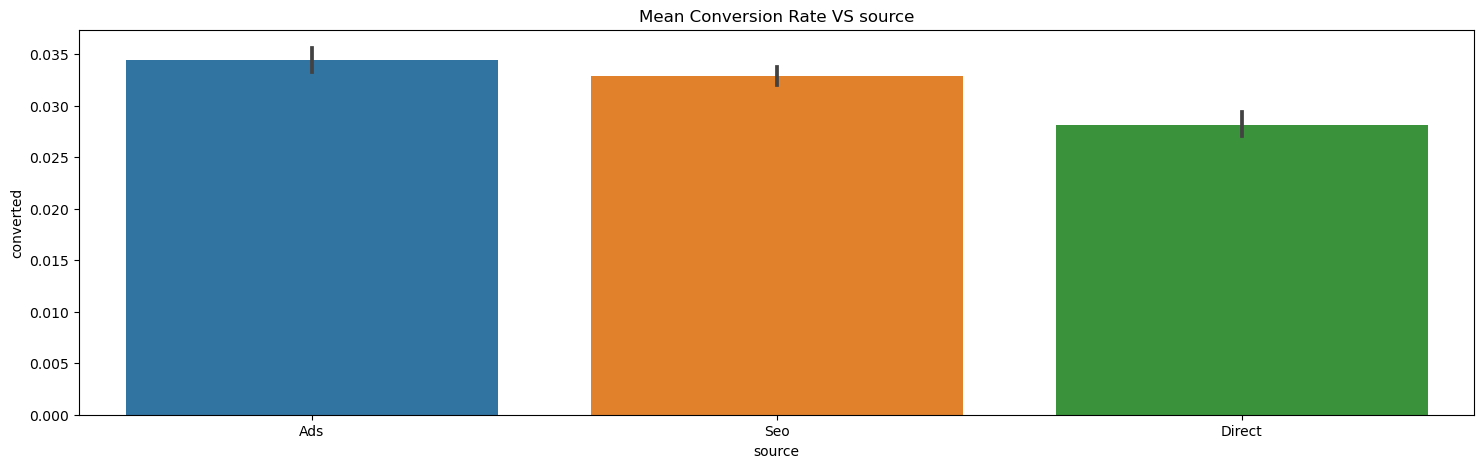

In [12]:
plt.figure(figsize=(18,5))
sns.barplot(x='source', y='converted', data=df)
plt.title('Mean Conversion Rate VS source');

The number (count) of converted Seo resources is relatively large

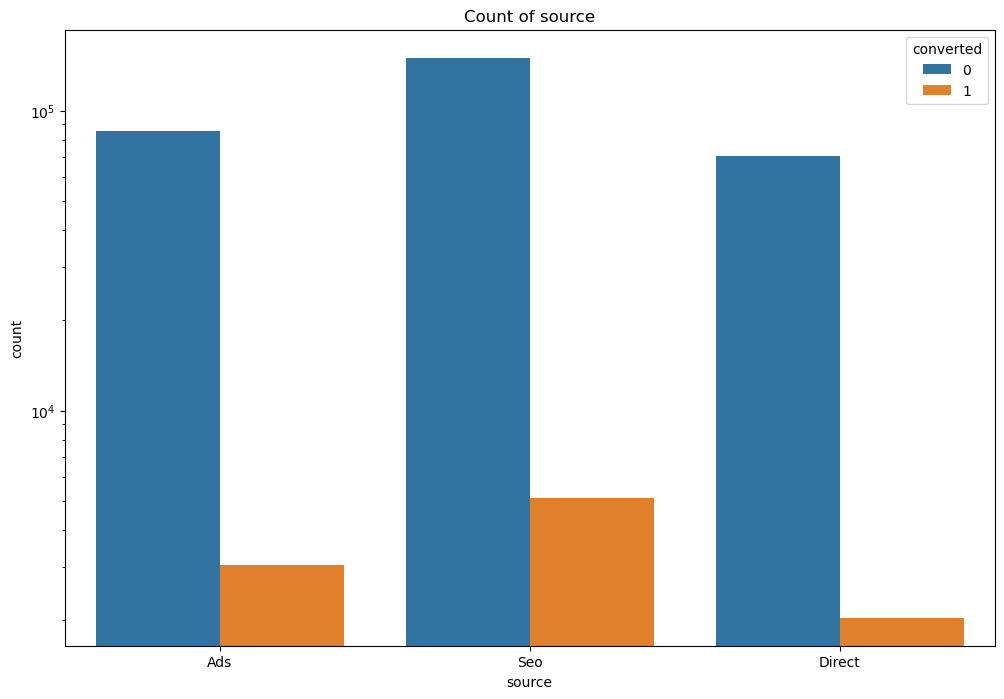

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(x='source', hue='converted', data=df)
plt.title('Count of source')
plt.yscale('log');

##### Age and conversion rate
Deep into the age group, 
- converted people mostly around early 20s, 
- un-converted people mostly around 30s (older than the converted one)

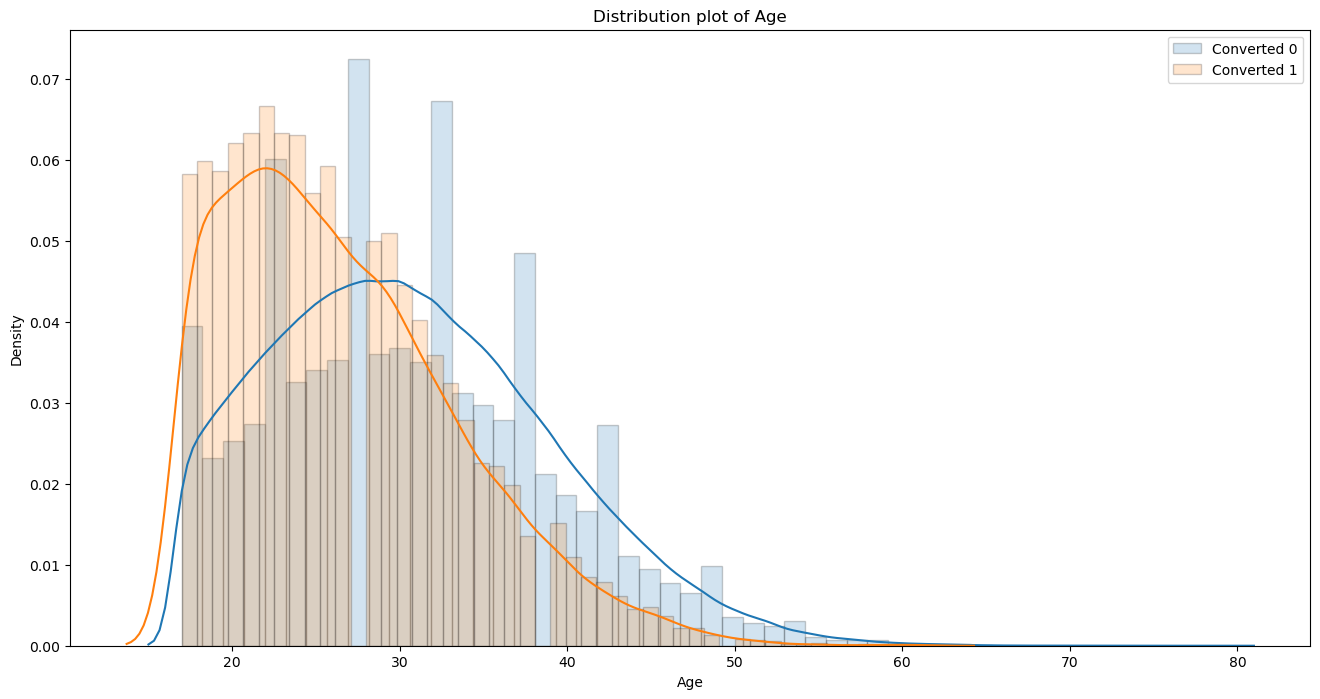

In [14]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
sns.distplot(df[df['converted'] == 0]['age'], label='Converted 0', hist_kws = hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label='Converted 1', hist_kws = hist_kws)
plt.legend()
plt.title('Distribution plot of Age')
plt.xlabel('Age');
# y axis is the probability density function for the kernel density estimation
# distplot usually used for two distplot comparison

The correlation between converted rate and age
- generally, with the increasing of age, the converted rate keep decreasing (negative crrelation)
- some fluctuation around age 60

In [15]:
mean_age = df.groupby('age')['converted'].mean().reset_index()
mean_age.head()

,age,converted
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


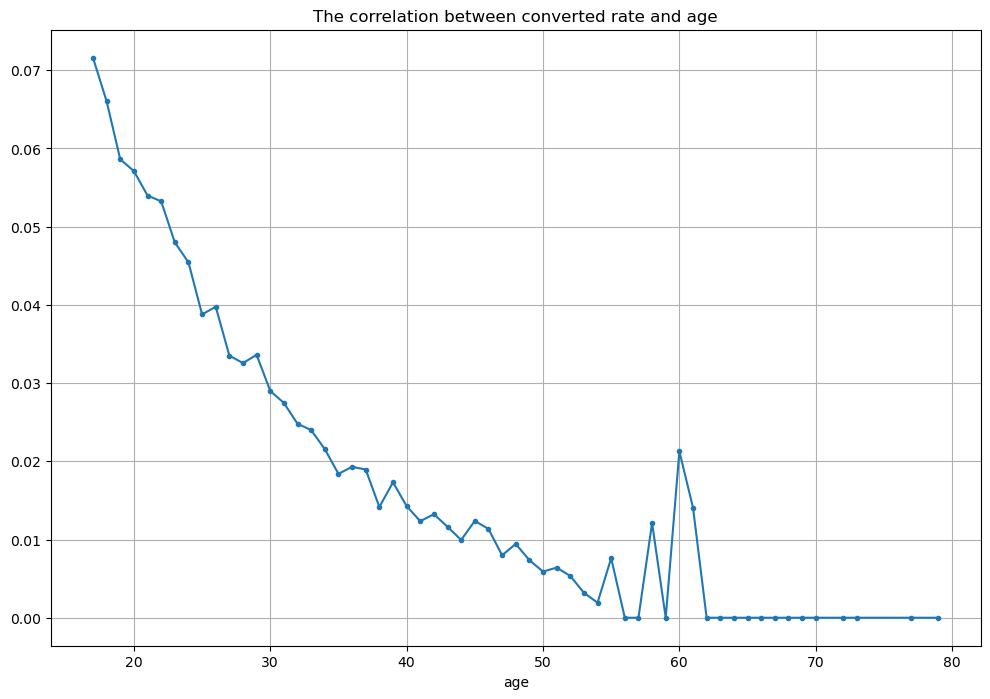

In [16]:
plt.figure(figsize=(12,8))
plt.plot(mean_age['age'], mean_age['converted'], '.-')
plt.title('The correlation between converted rate and age')
plt.xlabel('age')
plt.grid(True);

##### Total page visited and conversion rate
correlation between converted rate and page visited
- with number of page visited increasing, the converted rate increasing (positive)

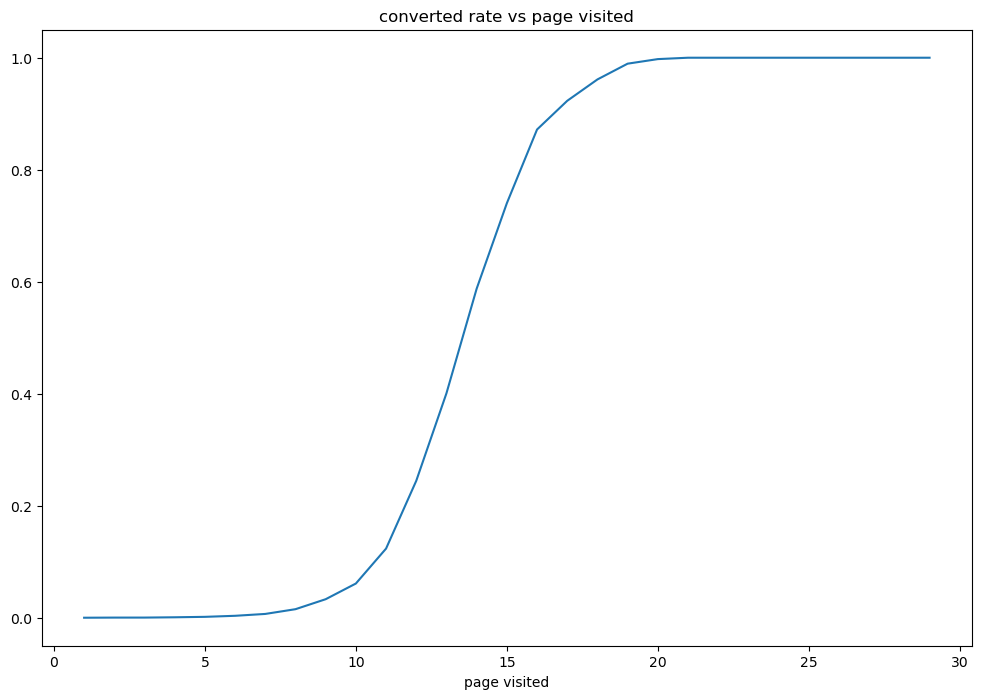

In [17]:
plt.figure(figsize=(12,8))
mean_page = df.groupby('total_pages_visited')['converted'].mean().reset_index()
plt.plot(mean_page['total_pages_visited'], mean_page['converted'])
plt.title('converted rate vs page visited')
plt.xlabel('page visited');

for the converted people, they viwed the page mostly around 15

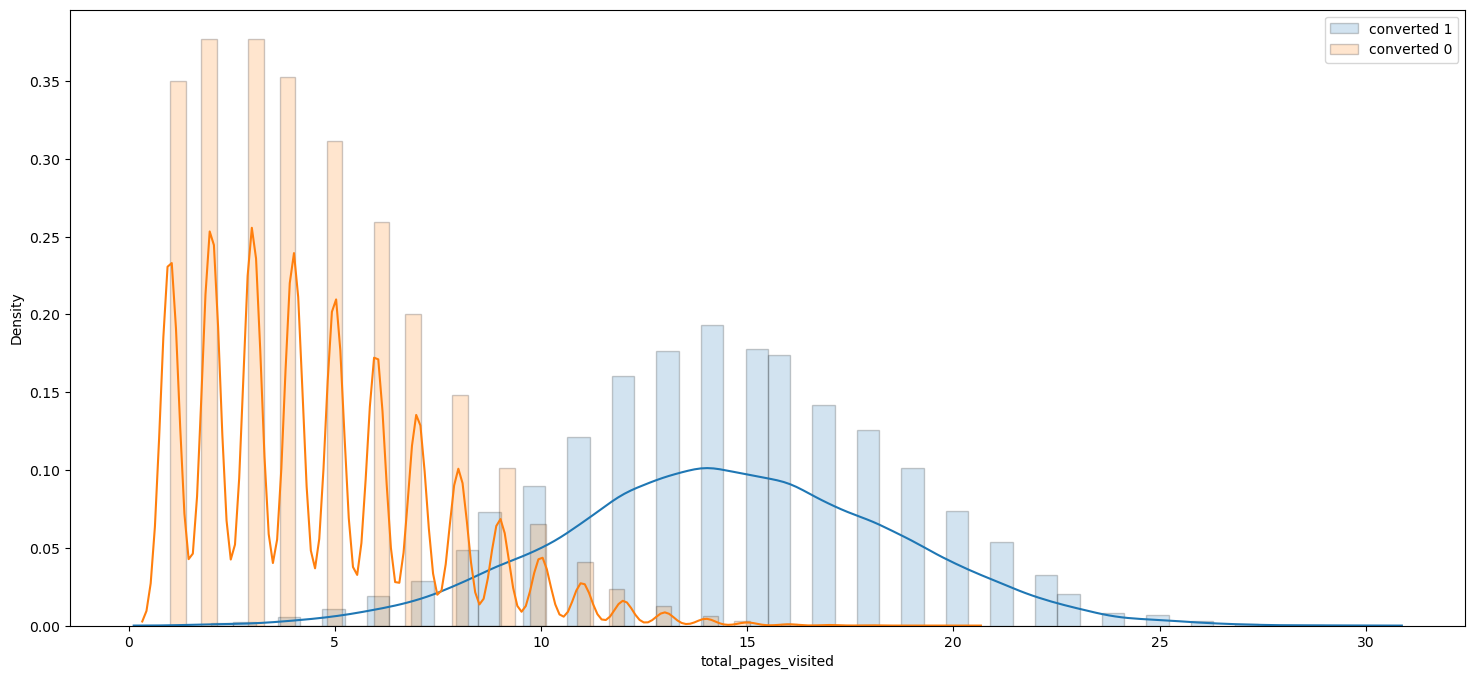

In [18]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}
plt.figure(figsize=(18,8))
sns.distplot(df[df['converted']==1]['total_pages_visited'], label = 'converted 1', hist_kws = hist_kws)
sns.distplot(df[df['converted']==0]['total_pages_visited'], label = 'converted 0', hist_kws = hist_kws)
plt.legend();

#### 2. Machine Learning for Prediction
Let’s now build a model to predict conversion rate. Outcome is binary and we care about insights to give product and marketing team some ideas. We can probably choose among the following models:
- Logistic regression
- Decision Trees
- RuleFit (this is often your best choice)
- Random Forest in combination with partial dependence plots

(Explain why we picked it and say that with more time we would spend ~1 day trying other models/different params and we would pick the best.)

In [19]:
df_country = pd.get_dummies(df['country'], drop_first=True)
df = pd.concat([df,df_country], axis=1)

df_source = pd.get_dummies(df['source'], drop_first=True)
df = pd.concat([df, df_source], axis=1)
df.head()

,country,age,new_user,source,total_pages_visited,converted,Germany,UK,US,Direct,Seo
0,UK,25,1,Ads,1,0,0,1,0,0,0
1,US,23,1,Seo,5,0,0,0,1,0,1
2,US,28,1,Seo,4,0,0,0,1,0,1
3,China,39,1,Seo,5,0,0,0,0,0,1
4,US,30,1,Seo,6,0,0,0,1,0,1


##### Logistic regression

In [20]:
X = df.drop(['converted','country', 'source'], axis=1)
y = df['converted']
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
print(X_train)

        age  new_user  total_pages_visited  Germany  UK  US  Direct  Seo
123955   32         1                    2        0   0   1       1    0
152146   39         1                   10        0   0   1       1    0
102774   24         0                    4        0   0   1       0    0
5562     34         1                    5        0   1   0       0    1
84390    34         1                    8        0   0   1       0    1
...     ...       ...                  ...      ...  ..  ..     ...  ...
119880   32         0                    4        0   1   0       0    0
259179   29         1                    6        0   0   1       0    1
131933   40         1                    7        0   0   1       0    0
146868   23         0                    1        0   1   0       0    0
121959   34         1                    2        0   0   1       0    0

[211852 rows x 8 columns]


In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

intercept = model.intercept_
coeff = model.coef_
coef_list = list(coeff[0,:])
coef_df = pd.DataFrame({'Feature': list(X_train.columns),'Coefficient': coef_list})
print(coef_df)  

               Feature  Coefficient
0                  age    -0.075074
1             new_user    -1.687099
2  total_pages_visited     0.750327
3              Germany     3.238512
4                   UK     2.921283
5                   US     2.542718
6               Direct    -0.205496
7                  Seo     0.040739


In [23]:
predicted_prob = model.predict_proba(X_test)[:,1] ##

y_pred = model.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm['Total'] = np.sum(cm, axis=1)
cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
cm.columns = ['Predicted No', 'Predicted Yes', 'Total']
cm = cm.set_index([['Actual No', 'Actual Yes', 'Total']])

print(cm)

            Predicted No  Predicted Yes   Total
Actual No         100653            376  101029
Actual Yes           992           2325    3317
Total             101645           2701  104346


In [24]:
print(classification_report(y_test, y_pred))

#model.score(X_test,y_test): this internally calculate y_pred; basically same as 'classification_report'

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101029
           1       0.86      0.70      0.77      3317

    accuracy                           0.99    104346
   macro avg       0.93      0.85      0.88    104346
weighted avg       0.99      0.99      0.99    104346



### Model Performance Summary

From the model performance table, here are some observations:

- **Class Imbalance**: 
  - The dataset has an uneven class distribution, with a large number of actual negatives.

- **Precision**: 
  - **Formula**: `Precision = TP / (TP + FP)`  
  - Measures how many predicted positives are actual positives. 
  - **High FP cost**: 
    - In applications like spam detection (1 = spam, 0 = not spam), a false positive means labeling important emails as spam, which can result in data loss.

- **Recall**: 
  - **Formula**: `Recall = TP / (TP + FN)`  
  - Measures how many actual positives are correctly identified. 
  - **High FN cost**: 
    - In fraud detection or medical diagnosis, failing to identify fraud or a disease can have severe consequences.

- **F1-Score**: 
  - **Formula**: `F1 = 2 * (Precision * Recall) / (Precision + Recall)`  
  - Used when there is an uneven class distribution, providing a balance between Precision and Recall.

- **Accuracy**: 
  - **Formula**: `Accuracy = (TP + TN) / (TP + TN + FP + FN)`  
  - Reflects overall correctness but may not be reliable in cases with class imbalance. In business contexts, focusing on FN and FP is often more critical due to their associated costs.

**Note**: For this project, we focus on **False Negatives (FN)** and **False Positives (FP)** as these have significant business implications, including tangible and intangible costs.


In [25]:
feat_importances = coef_df #what we created before for coeff
feat_importances['importances'] = np.abs(feat_importances['Coefficient']) #coeff is feature importance
feat_importances.sort_values(by='importances', ascending=False, inplace=True)
feat_importances

,Feature,Coefficient,importances
3,Germany,3.238512,3.238512
4,UK,2.921283,2.921283
5,US,2.542718,2.542718
1,new_user,-1.687099,1.687099
2,total_pages_visited,0.750327,0.750327
6,Direct,-0.205496,0.205496
0,age,-0.075074,0.075074
7,Seo,0.040739,0.040739


focus on the new_user feature is important. Negative coeff means that users with old accounts converted more

#### Random forest
Ex: I am going to pick a random forest to predict conversion rate. I pick a random forest cause: it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights about how it got information from the variables. Also, I will build a simple tree to find the most obvious user segments and see if they agree with RF partial dependence plots.

In [26]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SelectFromModel
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# pipeline = Pipeline([('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),\
#                 ('clf', RandomForestClassifier())])
# params = {
#     'clf__max_features': ['sqrt',0.5],
#     'clf__criterion': ['gini','entropy']
# }

# cv = GridSearchCV(pipeline,param_grid=params, scoring='roc_auc',cv=3)
# cv.fit(X_train, y_train)

In [27]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
y_pred = forest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    101029
           1       0.81      0.69      0.75      3317

    accuracy                           0.99    104346
   macro avg       0.90      0.84      0.87    104346
weighted avg       0.98      0.99      0.98    104346



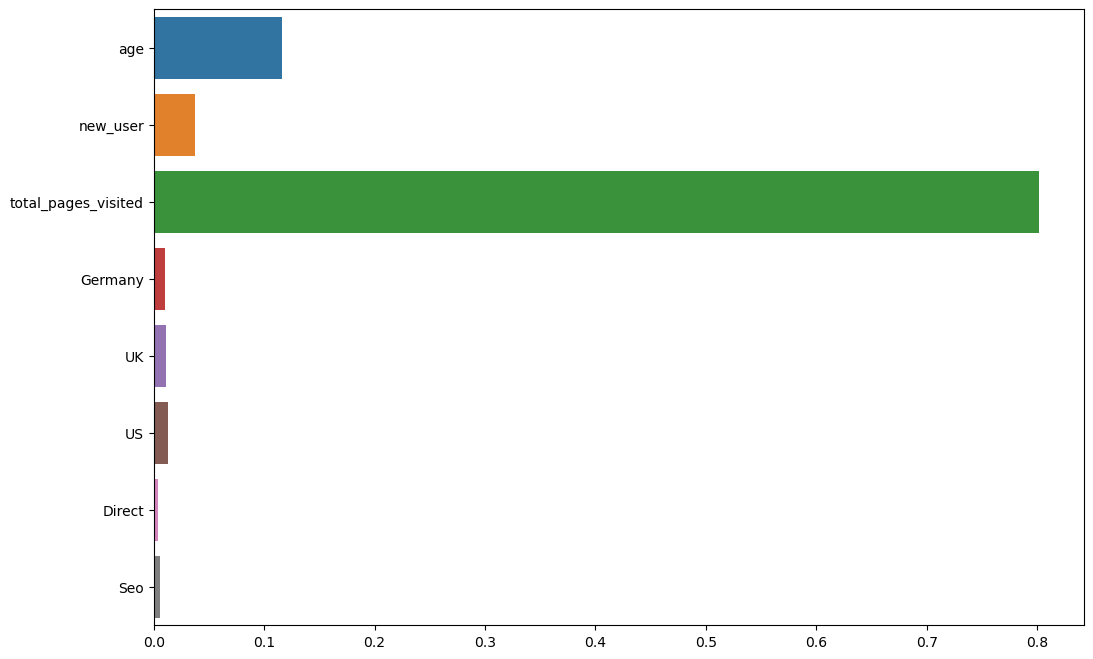

In [29]:
plt.figure(figsize=(12,8))
sns.barplot(x=forest.feature_importances_, y=X.columns);

In [30]:
feature_importance = pd.DataFrame({'Feature': list(X_train.columns), 'Importance':forest.feature_importances_})
feature_importance.sort_values(by='Importance',ascending=False, inplace=False)

,Feature,Importance
2,total_pages_visited,0.802056
0,age,0.116486
1,new_user,0.037376
5,US,0.012815
4,UK,0.011462
3,Germany,0.010205
7,Seo,0.005329
6,Direct,0.004271


From the chart above, the most important feature is total_pages_visited. However, it is difficult for the company to cause people to visit more pages. Also, people probably visit more pages to buy things anyway, so it is probably caused by the action of a purchase, rather than causing a purchase. 

Now I will remove total_pages_visited since it is now really helpful to the company.

In [31]:
remove_page = X.drop(['total_pages_visited'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(remove_page,y, test_size=0.33, random_state=42)
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
y_pred = forest.predict(X_test)
forest.score(X_test,y_test)

0.9682115270350564

In [33]:
feature_importance = pd.DataFrame({'Feature': list(X_train.columns), 'Importance':forest.feature_importances_})
feature_importance.sort_values(by='Importance',ascending=False, inplace=False)

,Feature,Importance
1,new_user,0.402784
0,age,0.308421
4,US,0.102163
3,UK,0.098844
2,Germany,0.068675
5,Direct,0.011093
6,Seo,0.008020


After removing the total_pages_visited the most important feature is now whether the user is a new user or not.



In [34]:
# Decision tree

clf = tree.DecisionTreeClassifier(max_depth=3,class_weight={0: 0.7, 1: 0.3})
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.7, 1: 0.3}, max_depth=3)

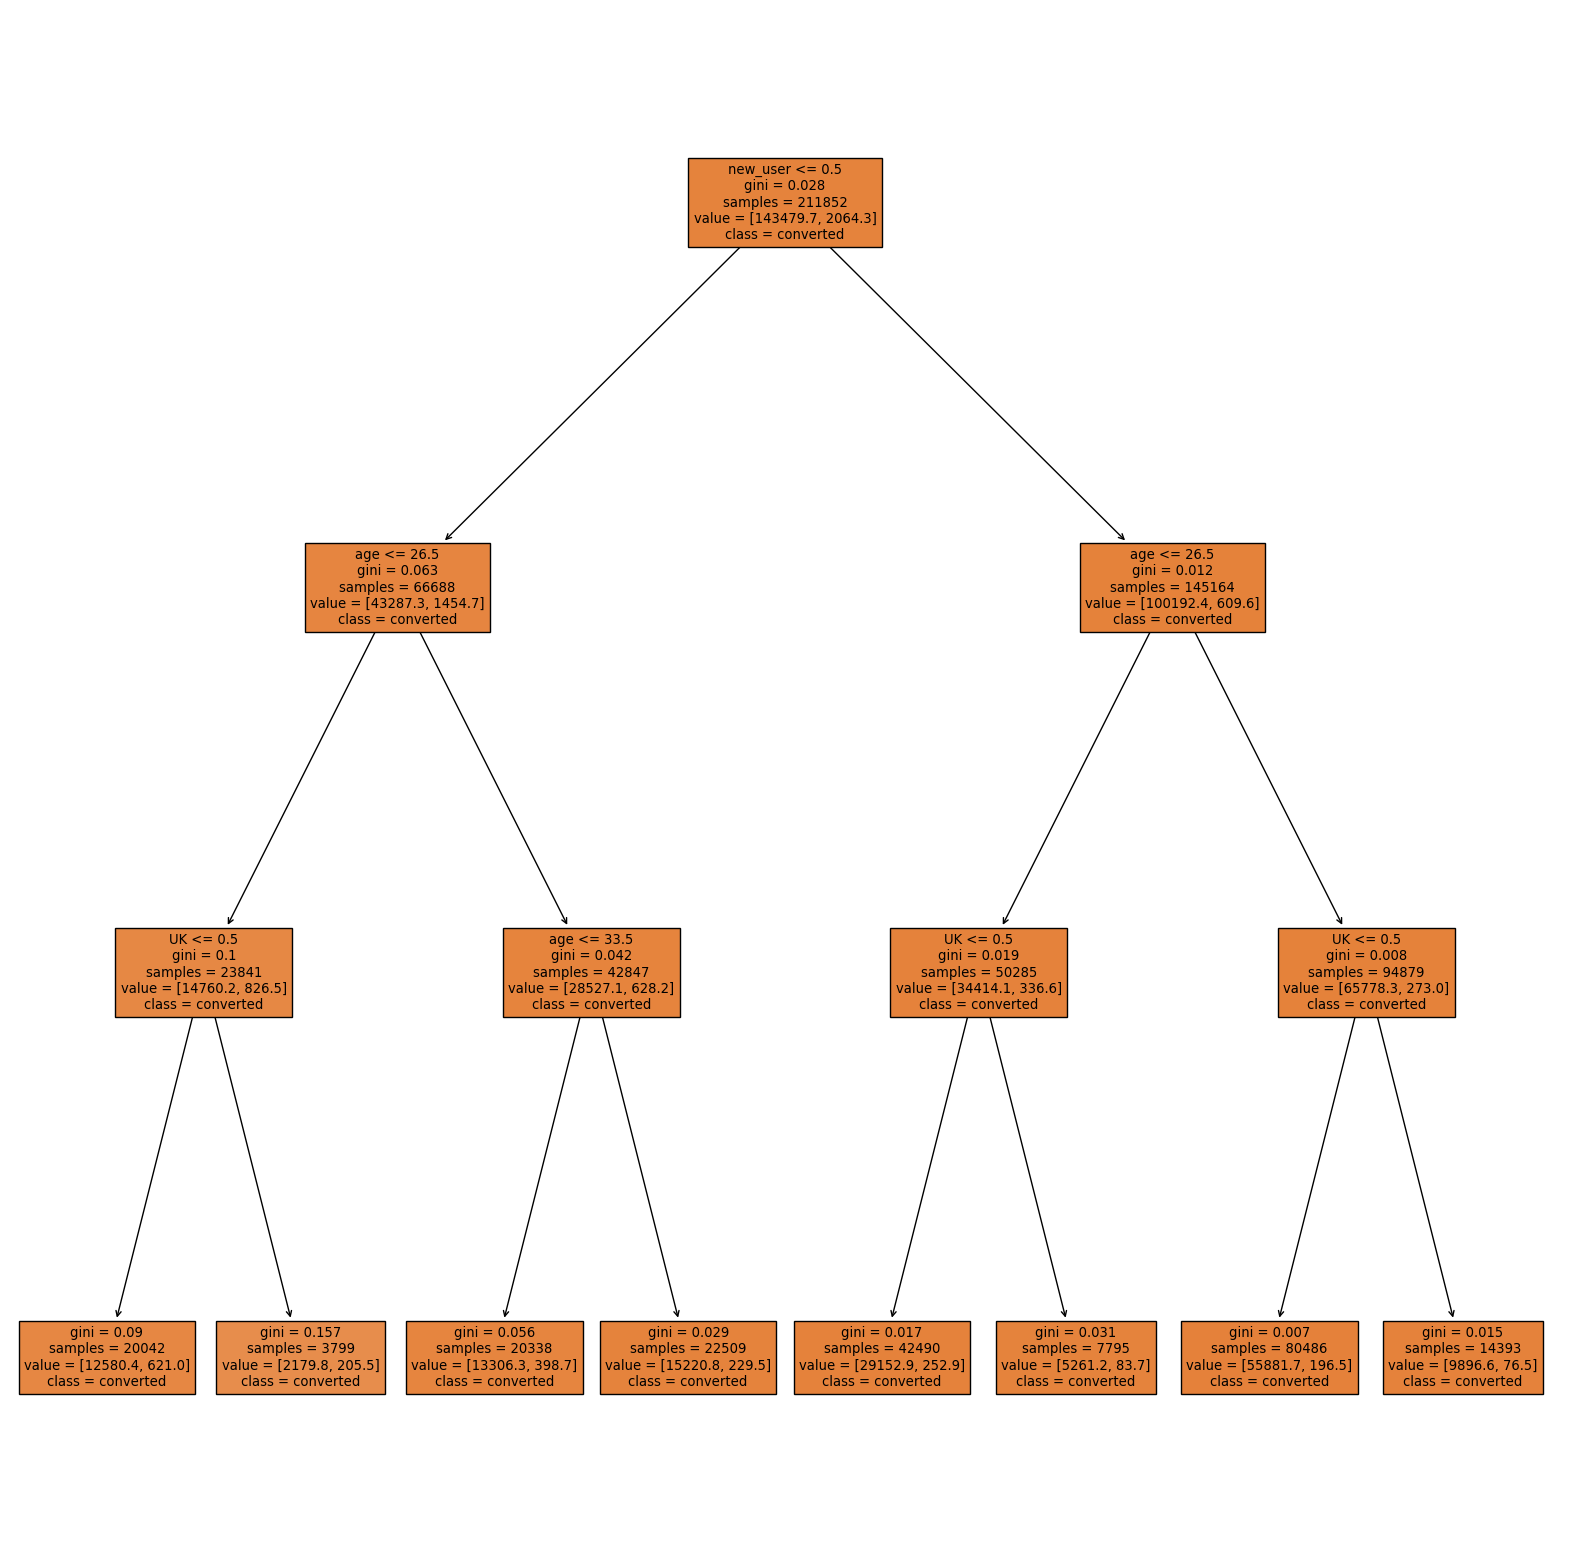

In [36]:
# Visualization

plt.figure(figsize=(20,20))
tree.plot_tree(clf.fit(X_train, y_train),feature_names=list(X_train.columns), class_names=['converted'], filled=True) 
plt.show()

Some conclusions and suggestions:
1. The site is working very well for **young users**. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.
2. The site is working very well for **Germany** in terms of conversion. But the summary showed that there are **few Germans coming to the site**: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
3. Users with **old accounts** do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.
4. Something is wrong with the **Chinese** version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why **older users** perform so poorly? From 30 y/o conversion clearly starts dropping.
6. If I know someone has **visited many pages**, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.


1. tell marketing to **get more of the good performing user segments**
2. tell product to **fix the experience for the bad performing ones**